In [1]:
library(tidyverse)
library(magrittr)
library(cowplot)
library(martini)
library(caret)

wd <- "../datasets/scones1_ex/"

pedBasename = paste0(wd, "genotype")
phenoFile = paste0(wd, "phenotype.txt")
netFile = paste0(wd, "network.txt")
encoding = 0
maf = 0.05

d <- readGWAS(pedBasename, phenoFile, netFile, encoding, maf)

SKAT <- 0
CHISQ <- 1

CONSISTENCY <- 1
AICc <- 2

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: igraph

Attaching package: ‘igraph’

The following object is masked from ‘package:magrittr’:

    %>%

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    %>%, compose, simplify

The following ob

We introduced the changes suggested in the previous notebook ie:

* More exhaustive grid search.
* Evaluation of the AICc.

# More exhaustive grid search

In [2]:
truth <- runGin(d$X, d$Y, d$net, list())$indicator

## Effect on AICc and CONSISTENCY

### On balanced accuracy

We will use the balanced accuracy, which is the mean between sensitivity ie TP/P and specificity ie TN/N.

In [3]:
# CONSISTENCY
skat.cons.sets <- list(test_statistic = SKAT, 
                       gridsearch_depth = 3, 
                       selection_criterion = CONSISTENCY)
skat.cons <- runGin(d$X, d$Y, d$net, skat.cons.sets)
skat.cons.stats <- confusionMatrix(skat.cons$indicator, truth, positive = '1')

# AICc
skat.info.sets <- list(test_statistic = SKAT, 
                       gridsearch_depth = 3, 
                       selection_criterion = AICc)
skat.info <- runGin(d$X, d$Y, d$net, skat.info.sets)
skat.info.stats <- confusionMatrix(skat.info$indicator, truth, positive = '1')

In [4]:
skat.cons.stats$byClass[["Balanced Accuracy"]]
skat.info.stats$byClass[["Balanced Accuracy"]]

[1] 0.6666667

[1] 0.9914228

In [5]:
# CONSISTENCY
chisq.cons.sets = list(test_statistic = CHISQ, 
                       gridsearch_depth = 3, 
                       selection_criterion = CONSISTENCY)
chisq.cons <- runGin(d$X, d$Y, d$net, chisq.cons.sets)
chisq.cons.stats <- confusionMatrix(chisq.cons$indicator, truth, positive = '1')

# AICc
chisq.sets = list(test_statistic = CHISQ, 
                  gridsearch_depth = 3, 
                  selection_criterion = AICc)
chisq.info <- runGin(d$X, d$Y, d$net, chisq.sets)
chisq.info.stats <- confusionMatrix(chisq.info$indicator, truth, positive = '1')

In [6]:
chisq.cons.stats$byClass[["Balanced Accuracy"]]
chisq.info.stats$byClass[["Balanced Accuracy"]]

[1] 0.6111111

[1] 0.9914228

Clearly, the grid depth doesn't help for CONSISTENCY, as we are getting worse results than in [simplest_example_1.ipynb](simplest_example_1.ipynb) with only one iteration. However, it is working for AICc, and particularly in the CHISQ, where the increase is greater.

[1] 26

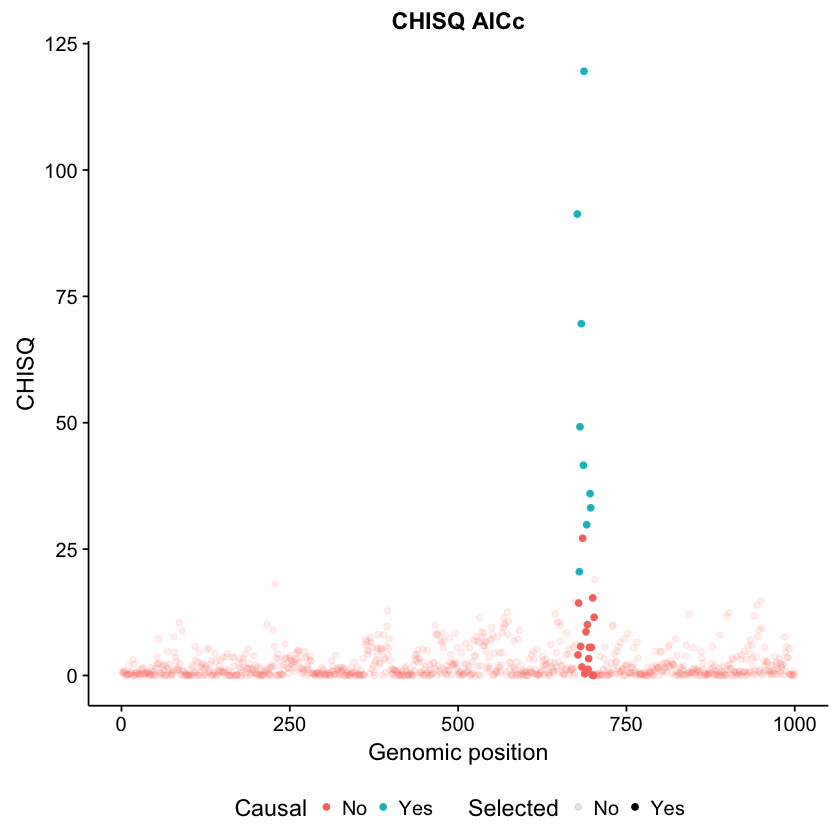

In [7]:
data.frame(y = chisq.info$scores, selected = chisq.info$indicator, causal = truth) %>%
    mutate(x = 1:n()) %>%
    ggplot(aes(x = x, color = ifelse(causal == 1, "Yes", "No"), 
               y = y, alpha = ifelse(selected == 1, "Yes", "No"))) +
        geom_point() +
        labs(x = "Genomic position", y = "CHISQ", 
             alpha = "Selected", color = "Causal",
             title = "CHISQ AICc") +
        theme(legend.position="bottom")

# number of positives
sum(chisq.info$indicator)

### Parameter selection

Optimal lambda and eta were 0.218011627679128 and 13.0694537180034. What we are finding is

In [8]:
chisq.info$lambda
chisq.info$eta

[1] 3.900418

[1] 5.580417

In [9]:
# "best solution"
best.opt.sets <- list(test_statistic = CHISQ, 
                       lambdas = c(0.218011627679128), 
                       etas = c(13.0694537180034), 
                       autoParameters = FALSE)

best <- runGin(d$X, d$Y, d$net, best.opt.sets)
best.stats <- getRegressionStats(d$X[,which(as.logical(best$indicator))], d$Y)
best.stats$AICc

# AICc solution
chisq.info.stats <- getRegressionStats(d$X[,which(as.logical(chisq.info$indicator))], d$Y)
chisq.info.stats$AICc

[1] 1457.792

[1] 1393.611

It seems that the new solution is more optimal according to AICc. For the moment, we can take it as a good approximation of reality. It seems counterintuitive though that a more sparse solution gets a worse AICc than the other solution.

In [10]:
best.p <- sum(best$indicator)
best.c <- sum(chisq.info$indicator)
n <- length(d$Y)
cat(-2 * best.stats$logLikelihood, "+", 
    2 * sum(best$indicator), "+", 
    (2 * best.p * ( best.p + 1)) / (n - best.p - 1), "\n")
cat(-2 * chisq.info.stats$logLikelihood, "+", 
    2 * sum(chisq.info$indicator), "+", 
    (2 * best.c * ( best.c + 1)) / (n - best.c - 1), "\n")

1435.251 + 20 + 0.4498978 
1336.408 + 52 + 2.968288 


We are picking the second model because the likelihood is higher which, in this context, means we are having some overfitting. Additionally, it seems that the effect of correction is neglibible. Maybe we can penalize higher the model complexity, using BIC instead.

In [11]:
# found SNPs
sum(chisq.info$indicator)
which(as.logical(chisq.info$indicator))

# causal SNPs
sum(best$indicator)
which(as.logical(best$indicator))

[1] 26

[1] 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695
[20] 696 697 698 699 700 701 702

[1] 10

[1] 677 680 681 683 685 686 687 691 696 697

The new solution involves includes all the true causal SNPs plus a set of nearby SNPs, which is not terrible. As we see, and the parameters let go, we would need to enforce more sparsity in comparison to connectivity.


# Comment on SCones consistency

The solution for this example is composed of 10 SNPs that are in a gene. The CONSISTENCY criteria only considers those answers with, at most, 1% of the SNPs. Given that we are studying 1000 SNPs, there is a bias towards the right solution. In the AICc criteria we relaxed this restriction to 10% of the SNPs. Maybe that is the reason that we aren't finding the optimal solution. The following cells are run with a special compilation where this threshold for CONSISTENCY has been raised to 10% too.

In [12]:
skat10 <- runGin(d$X, d$Y, d$net, list())

sum(skat10$indicator)
which(as.logical(skat10$indicator))

[1] 10

[1] 677 680 681 683 685 686 687 691 696 697

The SNPs that are found are the same as in AICc. Hence, the gain in accuracy is due to this artificial constraint.